In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from google.colab import files
from timeit import default_timer as timer

#PATHS & CONSTANTS
DATA_ROOT_DRIVE = "/content/drive/My Drive/images"
LOCAL_ROOT = "/content/images_local"

CHECKPOINT_DIR = "/content/drive/My Drive/emotion_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

SAVE_PATH = f"{CHECKPOINT_DIR}/best_tinyvgg.pth"
START_EPOCH_PATH = f"{CHECKPOINT_DIR}/last_epoch.txt"

if not os.path.exists(LOCAL_ROOT):
    print("کپی دیتاست به فضای محلی...")
    shutil.copytree(DATA_ROOT_DRIVE, LOCAL_ROOT)
    print("کپی تمام شد")
else:
    print("دیتاست آماده است")

TRAIN_DIR = f"{LOCAL_ROOT}/train"
VAL_DIR   = f"{LOCAL_ROOT}/validation"

# DEVICE & HYPERPARAMETERS
CLASSES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
EPOCHS = 20

train_transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# DATASETS & DATALOADERS
train_dataset = datasets.ImageFolder(TRAIN_DIR, train_transform)
val_dataset   = datasets.ImageFolder(VAL_DIR, test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)}")

# MODEL DEFINITION
class TinyVGG(nn.Module):
    def __init__(self):
        super().__init__()
        h = 32
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(3, h, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(h, h, 3, 1, 1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(h, h, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(h, h, 3, 1, 1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(h * 64 * 64, 7)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return self.classifier(x)

model = TinyVGG().to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# CHECKPOINT LOADING
start_epoch = 1
best_acc = 0.0

if os.path.exists(SAVE_PATH):
    print("مدل از Drive بارگذاری شد")
    model.load_state_dict(torch.load(SAVE_PATH, map_location=DEVICE))
    if os.path.exists(START_EPOCH_PATH):
        with open(START_EPOCH_PATH, 'r') as f:
            start_epoch = int(f.read().strip())
        print(f"ادامه آموزش از epoch {start_epoch}")
    else:
        print("فایل شماره epoch پیدا نشد → از ابتدا")
else:
    print("چک‌پوینت پیدا نشد → شروع از ابتدا")

# TRAINING & VALIDATION STEPS
def train_step(epoch):
    model.train()
    total_loss = correct = total = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} - Train", leave=False)
    for X, y in pbar:
        X, y = X.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (pred.argmax(1) == y).sum().item()
        total += y.size(0)
        pbar.set_postfix({'loss': f'{total_loss/(pbar.n+1):.4f}', 'acc': f'{correct/total:.4f}'})
    return total_loss / len(train_loader), correct / total

def val_step():
    model.eval()
    total_loss = correct = total = 0
    with torch.no_grad():
        for X, y in tqdm(val_loader, desc="Validation", leave=False):
            X, y = X.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
            pred = model(X)
            loss = loss_fn(pred, y)
            total_loss += loss.item()
            correct += (pred.argmax(1) == y).sum().item()
            total += y.size(0)
    return total_loss / len(val_loader), correct / total

#  MAIN TRAINING LOOP
print("\nآموزش شروع شد...\n")
total_start = timer()

for epoch in range(start_epoch, EPOCHS + 1):
    epoch_start = timer()
    train_loss, train_acc = train_step(epoch)
    val_loss, val_acc = val_step()

    epoch_time = (timer() - epoch_start) / 60
    remaining = (EPOCHS - epoch) * epoch_time if epoch_time > 0 else 0

    status = f"[{epoch:2d}/{EPOCHS}] Train: {train_loss:.4f}/{train_acc:.4f}  Val: {val_loss:.4f}/{val_acc:.4f}  زمان: {epoch_time:.1f} دقیقه"

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), SAVE_PATH)
        with open(START_EPOCH_PATH, 'w') as f:
            f.write(str(epoch + 1))
        status += f"  ★ بهترین دقت ({val_acc:.4f}) ذخیره شد در Drive"

    print(status)
    print(f"   تخمین زمان باقی‌مانده: {remaining:.1f} دقیقه\n")

#  FINAL SUMMARY
print(f"\nآموزش تمام شد | بهترین Val Acc: {best_acc:.4f}")
print(f"زمان کل: {(timer() - total_start)/60:.1f} دقیقه")
print(f"مدل نهایی در: {SAVE_PATH}")

model.load_state_dict(torch.load(SAVE_PATH, map_location=DEVICE))
model.eval()
print("مدل بهترین بارگذاری شد ✓")


عکس(ها) را آپلود کنید:


Saving images.jfif to images (5).jfif


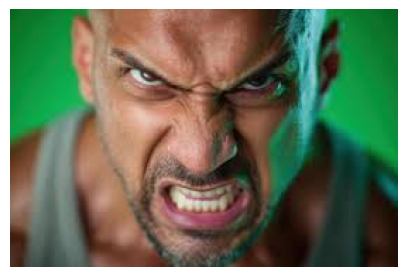

→ احساس پیش‌بینی‌شده: ANGRY   اطمینان: 72.4%



In [ ]:
# TEST ON PIC(1)
def predict_upload():
    print("\nعکس را آپلود کنید:")
    uploaded = files.upload()
    for fn in uploaded.keys():
        img = Image.open(fn).convert('RGB')
        plt.figure(figsize=(5,5))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        tensor = test_transform(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            out = model(tensor)
            probs = torch.softmax(out, 1)[0]
            idx = probs.argmax().item()
            conf = probs[idx].item()
        print(f"→ احساس پیش‌بینی‌شده: {CLASSES[idx].upper()}   اطمینان: {conf:.1%}\n")

predict_upload()


عکس(ها) را آپلود کنید:


Saving images (5).jfif to images (5) (2).jfif


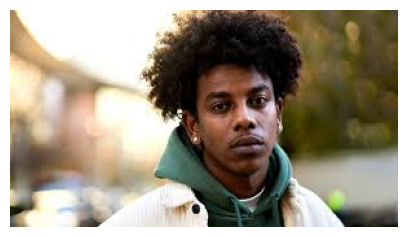

→ احساس پیش‌بینی‌شده: NEUTRAL   اطمینان: 69.8%



In [ ]:
# TEST ON PIC(2)
def predict_upload():
    print("\nعکس را آپلود کنید:")
    uploaded = files.upload()
    for fn in uploaded.keys():
        img = Image.open(fn).convert('RGB')
        plt.figure(figsize=(5,5))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        tensor = test_transform(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            out = model(tensor)
            probs = torch.softmax(out, 1)[0]
            idx = probs.argmax().item()
            conf = probs[idx].item()
        print(f"→ احساس پیش‌بینی‌شده: {CLASSES[idx].upper()}   اطمینان: {conf:.1%}\n")

predict_upload()


عکس(ها) را آپلود کنید:


Saving istockphoto-182778290-612x612.jpg to istockphoto-182778290-612x612.jpg


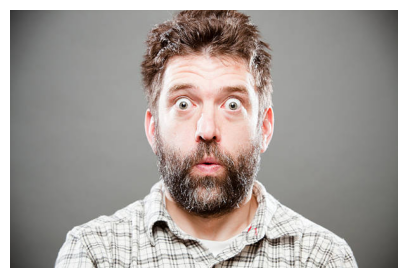

→ احساس پیش‌بینی‌شده: FEAR   اطمینان: 48.3%



In [ ]:
# TEST ON PIC(3)
def predict_upload():
    print("\nعکس را آپلود کنید:")
    uploaded = files.upload()
    for fn in uploaded.keys():
        img = Image.open(fn).convert('RGB')
        plt.figure(figsize=(5,5))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        tensor = test_transform(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            out = model(tensor)
            probs = torch.softmax(out, 1)[0]
            idx = probs.argmax().item()
            conf = probs[idx].item()
        print(f"→ احساس پیش‌بینی‌شده: {CLASSES[idx].upper()}   اطمینان: {conf:.1%}\n")

predict_upload()


عکس(ها) را آپلود کنید:


Saving 360_F_223872480_DSwm8RxTh9MwICUuDR9viwndJCqKHiaK.jpg to 360_F_223872480_DSwm8RxTh9MwICUuDR9viwndJCqKHiaK.jpg


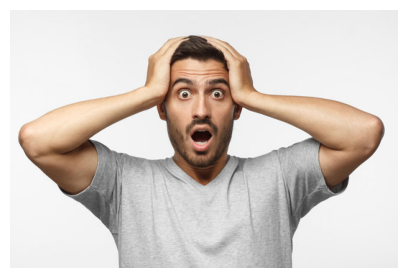

→ احساس پیش‌بینی‌شده: SURPRISE   اطمینان: 50.8%



In [ ]:
# TEST ON PIC(4)
def predict_upload():
    print("\nعکس را آپلود کنید:")
    uploaded = files.upload()
    for fn in uploaded.keys():
        img = Image.open(fn).convert('RGB')
        plt.figure(figsize=(5,5))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        tensor = test_transform(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            out = model(tensor)
            probs = torch.softmax(out, 1)[0]
            idx = probs.argmax().item()
            conf = probs[idx].item()
        print(f"→ احساس پیش‌بینی‌شده: {CLASSES[idx].upper()}   اطمینان: {conf:.1%}\n")

predict_upload()


عکس(ها) را آپلود کنید:


Saving 11202.jpg to 11202.jpg


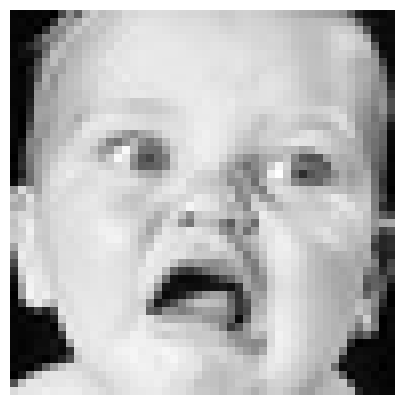

→ احساس پیش‌بینی‌شده: DISGUST   اطمینان: 22.8%



In [ ]:
# TEST ON PIC(5)
def predict_upload():
    print("\nعکس را آپلود کنید:")
    uploaded = files.upload()
    for fn in uploaded.keys():
        img = Image.open(fn).convert('RGB')
        plt.figure(figsize=(5,5))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        tensor = test_transform(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            out = model(tensor)
            probs = torch.softmax(out, 1)[0]
            idx = probs.argmax().item()
            conf = probs[idx].item()
        print(f"→ احساس پیش‌بینی‌شده: {CLASSES[idx].upper()}   اطمینان: {conf:.1%}\n")

predict_upload()


عکس(ها) را آپلود کنید:


Saving 9.jpg to 9.jpg


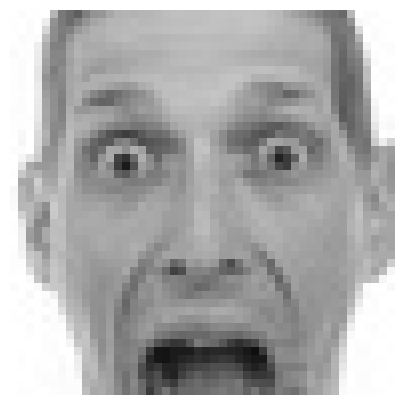

→ احساس پیش‌بینی‌شده: FEAR   اطمینان: 40.4%



In [ ]:
# TEST ON PIC(6)
def predict_upload():
    print("\nعکس را آپلود کنید:")
    uploaded = files.upload()
    for fn in uploaded.keys():
        img = Image.open(fn).convert('RGB')
        plt.figure(figsize=(5,5))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        tensor = test_transform(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            out = model(tensor)
            probs = torch.softmax(out, 1)[0]
            idx = probs.argmax().item()
            conf = probs[idx].item()
        print(f"→ احساس پیش‌بینی‌شده: {CLASSES[idx].upper()}   اطمینان: {conf:.1%}\n")

predict_upload()


عکس(ها) را آپلود کنید:


Saving 233.jpg to 233.jpg


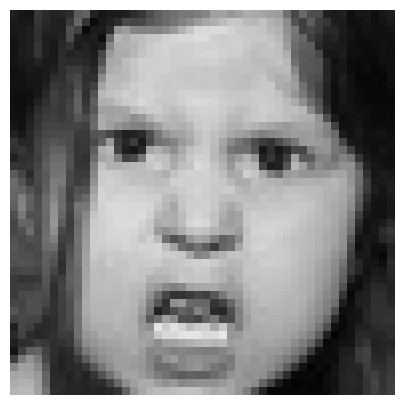

→ احساس پیش‌بینی‌شده: ANGRY   اطمینان: 41.0%



In [ ]:
# TEST ON PIC(7)
def predict_upload():
    print("\nعکس را آپلود کنید:")
    uploaded = files.upload()
    for fn in uploaded.keys():
        img = Image.open(fn).convert('RGB')
        plt.figure(figsize=(5,5))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        tensor = test_transform(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            out = model(tensor)
            probs = torch.softmax(out, 1)[0]
            idx = probs.argmax().item()
            conf = probs[idx].item()
        print(f"→ احساس پیش‌بینی‌شده: {CLASSES[idx].upper()}   اطمینان: {conf:.1%}\n")

predict_upload()


عکس(ها) را آپلود کنید:


Saving 293.jpg to 293.jpg


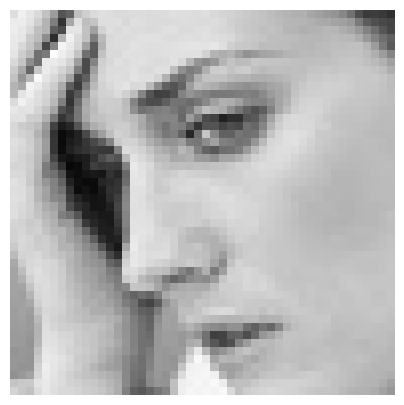

→ احساس پیش‌بینی‌شده: SAD   اطمینان: 32.6%



In [ ]:
# TEST ON PIC(8)
def predict_upload():
    print("\nعکس را آپلود کنید:")
    uploaded = files.upload()
    for fn in uploaded.keys():
        img = Image.open(fn).convert('RGB')
        plt.figure(figsize=(5,5))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        tensor = test_transform(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            out = model(tensor)
            probs = torch.softmax(out, 1)[0]
            idx = probs.argmax().item()
            conf = probs[idx].item()
        print(f"→ احساس پیش‌بینی‌شده: {CLASSES[idx].upper()}   اطمینان: {conf:.1%}\n")

predict_upload()


عکس(ها) را آپلود کنید:


Saving 14.jpg to 14.jpg


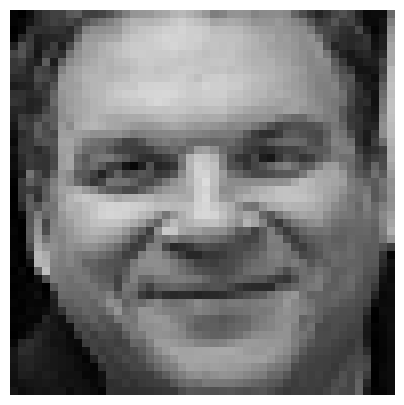

→ احساس پیش‌بینی‌شده: HAPPY   اطمینان: 93.9%



In [ ]:
# TEST ON PIC(9)
def predict_upload():
    print("\nعکس را آپلود کنید:")
    uploaded = files.upload()
    for fn in uploaded.keys():
        img = Image.open(fn).convert('RGB')
        plt.figure(figsize=(5,5))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        tensor = test_transform(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            out = model(tensor)
            probs = torch.softmax(out, 1)[0]
            idx = probs.argmax().item()
            conf = probs[idx].item()
        print(f"→ احساس پیش‌بینی‌شده: {CLASSES[idx].upper()}   اطمینان: {conf:.1%}\n")

predict_upload()


عکس(ها) را آپلود کنید:


Saving 250.jpg to 250.jpg


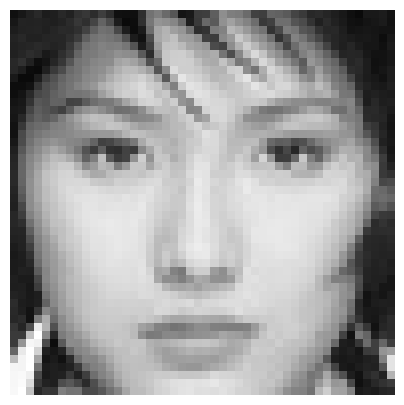

→ احساس پیش‌بینی‌شده: NEUTRAL   اطمینان: 49.3%



In [ ]:
# TEST ON PIC(10)
def predict_upload():
    print("\nعکس(ها) را آپلود کنید:")
    uploaded = files.upload()
    for fn in uploaded.keys():
        img = Image.open(fn).convert('RGB')
        plt.figure(figsize=(5,5))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        tensor = test_transform(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            out = model(tensor)
            probs = torch.softmax(out, 1)[0]
            idx = probs.argmax().item()
            conf = probs[idx].item()
        print(f"→ احساس پیش‌بینی‌شده: {CLASSES[idx].upper()}   اطمینان: {conf:.1%}\n")

predict_upload()

In [ ]:
#INSTALLS FOR TEST ON VIDEO
!pip install torch torchvision torchaudio
!pip install opencv-python pillow numpy tqdm matplotlib ipython

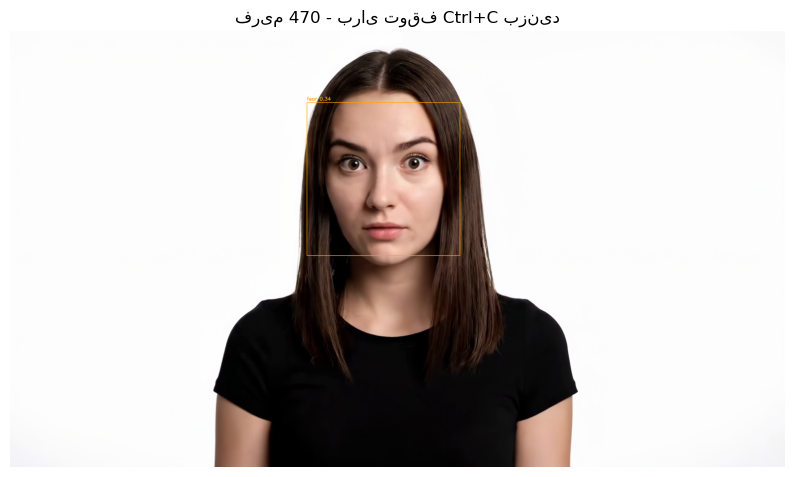


پردازش: 100%|████████████████████████████████████████████████████████████████████████| 478/478 [06:39<00:00,  1.20it/s]

ویدیو خروجی ذخیره شد: output_emotion.mp4


In [ ]:
#TEST ON VIDEO

#IMPORTS & SETUP
import cv2
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import time

#MODEL & DEVICE
MODEL_PATH = "best_tinyvgg.pth"

class TinyVGG(torch.nn.Module):
    def __init__(self):
        super().__init__()
        h = 32
        self.conv_block_1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, h, 3, 1, 1), torch.nn.ReLU(),
            torch.nn.Conv2d(h, h, 3, 1, 1), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.conv_block_2 = torch.nn.Sequential(
            torch.nn.Conv2d(h, h, 3, 1, 1), torch.nn.ReLU(),
            torch.nn.Conv2d(h, h, 3, 1, 1), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(h * 64 * 64, 7)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return self.classifier(x)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TinyVGG().to(DEVICE)

if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    print(f"مدل بارگذاری شد: {MODEL_PATH}")
else:
    print(f"فایل مدل پیدا نشد: {MODEL_PATH}")
    raise FileNotFoundError("مدل را در مسیر درست بگذارید")

model.eval()

#TRANSFORMS & CLASSES
test_transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

CLASSES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

#FACE DETECTOR
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

if face_cascade.empty():
    print("خطا: Haar Cascade بارگذاری نشد.")
    raise Exception("OpenCV درست نصب نشده یا haarcascade موجود نیست")

# VIDEO INPUT / OUTPUT
input_video = "video1.mp4"
# for webcam: input_video = 0

output_video = "output_emotion.mp4"

cap = cv2.VideoCapture(input_video)

if not cap.isOpened():
    print("خطا: ویدیو یا وبکم باز نشد. مسیر را چک کنید.")
    raise Exception("VideoCapture failed")

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"ویدیو: {width}x{height} @ {fps:.1f} fps - {total_frames} فریم")

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

# MAIN PROCESSING LOOP
frame_count = 0
pbar = tqdm(total=total_frames, desc="پردازش")

plt.ion()
fig, ax = plt.subplots(figsize=(10, 8))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    pbar.update(1)

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=4)

    for (x, y, w, h) in faces:
        face_crop = frame[y:y+h, x:x+w]
        if face_crop.size == 0:
            continue

        pil_face = Image.fromarray(cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB))
        tensor = test_transform(pil_face).unsqueeze(0).to(DEVICE, non_blocking=True)

        with torch.no_grad():
            out_pred = model(tensor)
            probs = torch.softmax(out_pred, dim=1)[0]
            idx = probs.argmax().item()
            conf = probs[idx].item()
            emotion = CLASSES[idx]

        color = (0, 255, 0) if conf > 0.6 else (0, 165, 255)
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        cv2.putText(frame, f"{emotion} {conf:.2f}", (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    out.write(frame)

    if frame_count % 10 == 0:
        clear_output(wait=True)
        ax.clear()
        ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        ax.set_title(f"فریم {frame_count} - برای توقف Ctrl+C بزنید")
        ax.axis('off')
        display(fig)
        time.sleep(0.01)

pbar.close()
cap.release()
out.release()
plt.close(fig)

print(f"ویدیو خروجی ذخیره شد: {output_video}")